In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy as sp

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import pacf as pacf_func
from statsmodels.graphics.tsaplots import acf as acf_func
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as tsa

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

plt.style.use('ggplot')

# <font face="gotham" color="purple"> AR Model </font>

Though the **Autoregressive model** rarely plays a role in practice, joined with **Moving Average model** they undoubted are the foundation of advanced techniques. Here is the standard form of $\text{AR(1)}$
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
If $\phi_1<1$, the series exhibits mean-reversion feature, and $\phi_1>1$ exhibits trend-following feature. 

As a reminder for ```statsmodels```, ```ArmaProcess``` object needs zero lag coefficient to be $1$ explicitly input and the signs from lag $1$ onward also must be reversed, e.g. plus sign reversed to minus.

## <font face="gotham" color="purple"> AR Simulation </font>

Codes below generate $\text{AR}$ series by specifying parameters. The guidance are written as comments along the codes.

In [2]:
ar_params = np.array([1, 0.9]) # alwasy specify zero lag as 1
ma_params = np.array([1]) # alwasy specify zero lag as 1
ar1 = ArmaProcess(ar_params, ma_params) # the Class requires AR and MA's parameters
ar1_sim = ar1.generate_sample(nsample=100)  
ar1_sim = pd.DataFrame(ar1_sim, columns = ['AR(1)']) 
ar1_acf = acf_func(ar1_sim.values, fft=False, nlags = 50)  # return the numerical ACF 

ar_params1 = np.array([1, -0.9])
ma_params1 = np.array([1])
ar1_pos = ArmaProcess(ar_params1, ma_params1)
ar1_sim_pos = ar1_pos.generate_sample(nsample=100)
ar1_sim_pos = pd.DataFrame(ar1_sim_pos, columns = ['AR(1)'])
ar1_acf_pos = acf_func(ar1_sim_pos.values, fft=False, nlags = 50)

ar_params2 = np.array([1, -0.8, -.2])
ma_params2 = np.array([1])
ar2 = ArmaProcess(ar_params2, ma_params2)
ar2_sim = ar2.generate_sample(nsample=100)
ar2_sim = pd.DataFrame(ar2_sim, columns = ['AR(2)'])
ar2_acf = acf_func(ar2_sim.values, fft=False, nlags = 50)

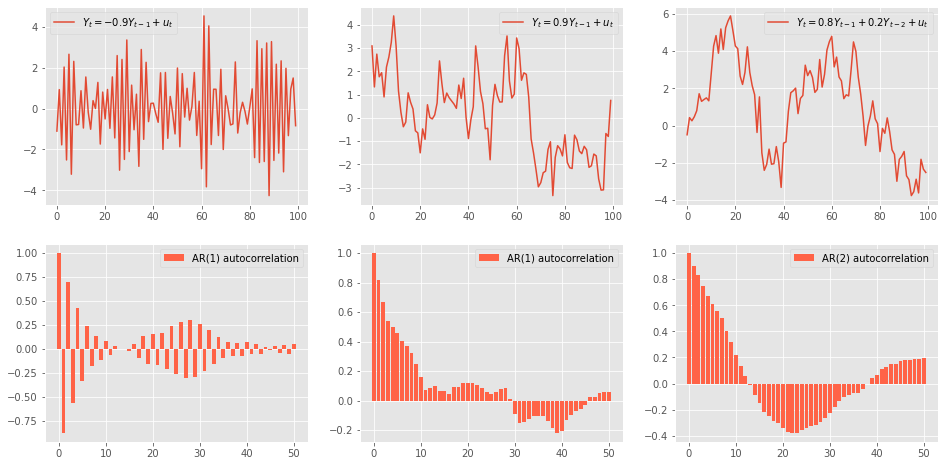

In [3]:
fig, ax = plt.subplots(figsize = (16, 8), nrows = 2, ncols = 3)
ax[0, 0].plot(ar1_sim, label='$Y_t = {%s}Y_{t-1}+u_t$'%(-ar_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(np.arange(len(ar1_acf)),ar1_acf, color = 'tomato', label = 'AR(1) autocorrelation')
ax[1, 0].legend()

ax[0, 1].plot(ar1_sim_pos, label='$Y_t = {%s}Y_{t-1}+u_t$'%(-ar_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(np.arange(len(ar1_acf_pos)),ar1_acf_pos, color = 'tomato', label = 'AR(1) autocorrelation')
ax[1, 1].legend()

ax[0, 2].plot(ar2_sim, label='$Y_t = {%s} Y_{t-1}+{%s} Y_{t-2}+u_t$'%(-ar_params2[1], -ar_params2[2]))
ax[0, 2].legend()
ax[1, 2].bar(np.arange(len(ar2_acf)),ar2_acf, color = 'tomato', label = 'AR(2) autocorrelation')
ax[1, 2].legend()
plt.show()

## <font face="gotham" color="purple"> Mechanism of Simulation </font>

In [78]:
np.random.seed(123)
#
m = 50
N = 150
epsilon = np.random.normal(loc = 0, scale = 0.5, size = N + m)
#
temp = np.array(1 + epsilon[0], ndmin = 1)
temp = np.append(temp, 1 + .8 * temp[0] + epsilon[1])

In [79]:

for j in range(2, N + m):
    Y_temp = 1 + 1.1 * temp[j - 1] - 0.2 * temp[j - 2] + epsilon[j]
    temp = np.append(temp, Y_temp)
#      

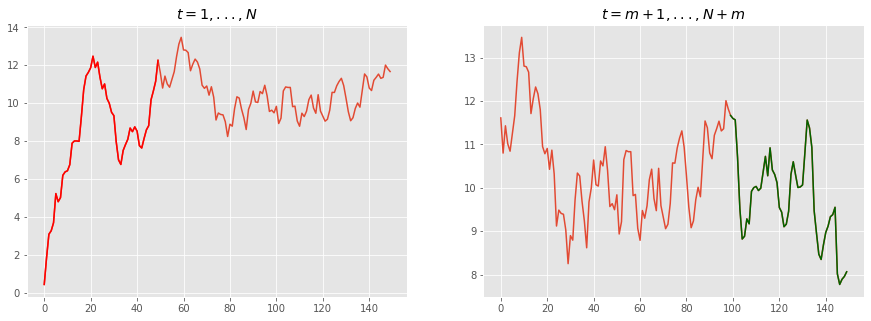

In [80]:
fig, ax = plt.subplots(figsize = (15, 5), nrows=1, ncols=2)
ax[0].plot(temp[:N])
ax[0].plot(list(range(0, m)), temp[:m], color = 'red')
ax[0].set_title("$t = 1, ..., N$")

ax[1].plot(temp[m:])
ax[1].plot(list(range(N - m - 1, N)), temp[(N - 1):], color = 'darkgreen')
ax[1].set_title("$t = m + 1,..., N+m$")
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of AR(1)</font> 

The estimation can be achieved by instantiating an object from ```ARIMA``` class. As you can see the class requires specifying the order for $\text{ARIMA}$ model, where $\text{I}$ means integrated, i.e. order of difference to render stationary. 

For instance, $\text{AR(1)}$ with $1st$ order stationary series can also be written as $\text{ARIMA(1, 0, 0)}$.

Output ```sigma2``` is the variance of residuals $\sigma^2$. 

This is the model we are estimating
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$

In [4]:
mod_obj = ARIMA(ar1_sim_pos, order=(1, 0, 0)) # input the order for ARIMA
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(1)   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -139.947
Date:                Sat, 15 Oct 2022   AIC                            285.893
Time:                        21:56:34   BIC                            293.709
Sample:                             0   HQIC                           289.056
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2880      0.553      0.521      0.602      -0.796       1.372
ar.L1          0.8327      0.056     14.857      0.000       0.723       0.943
sigma2         0.9505      0.140      6.779      0.0

In [5]:
res_predict = result.predict(start=5, end=110)

Plot both the simulated $\text{AR(1)}$ and the forecast/predicted series.

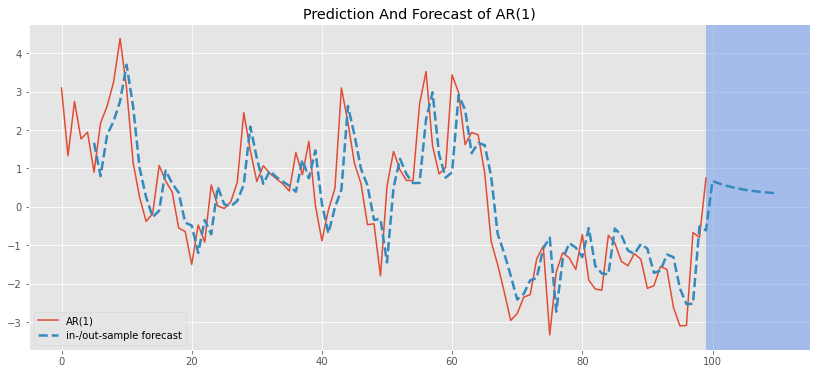

In [6]:
ar1_sim_pos.plot(figsize=(14, 6), label='simulated AR(1) series')
res_predict.plot(label = 'in-/out-sample forecast',\
                 title='Prediction And Forecast of AR(1)', ls='--', lw=2.5)
plt.axvspan(len(ar1_sim_pos)-1, len(ar1_sim_pos)+15, alpha=0.5, lw=0, color='CornflowerBlue')
plt.xlim([-5, 115])
plt.legend()
plt.show()

# <font face="gotham" color="purple">Identification of the Order of an AR Model </font>

The usual practice of order identification is called **the Box-Jenkins Methodology**, which will be explicated below, for now we simply perform two techniques:
1. Partial Autocorrelation Function
2. Akaike or Bayesian Information Criteria ($\text{AIC}$, $\text{BIC}$)

First, we will simulate a series, the true data generating process is given by $\text{AR(4)}$
$$
Y_{t}=-0.8 Y_{t-1}-0.2 Y_{t-2}+0.2Y_{t-3}+0.1Y_{t-4}+u_{t}
$$


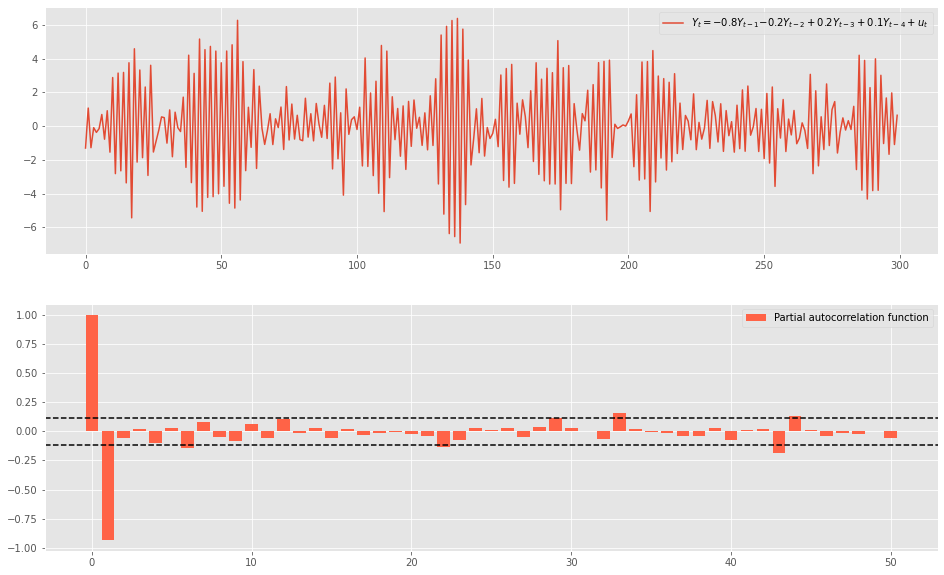

In [7]:
obs = 300

ar_params = np.array([1, 0.8, 0.2, -.2, -.1])
ma_params = np.array([1])
ar4 = ArmaProcess(ar_params, ma_params)
ar4_sim = ar1.generate_sample(nsample=obs)
ar4_sim = pd.DataFrame(ar4_sim, columns = ['AR(4)'])
ar4_pacf = pacf_func(ar4_sim.values, nlags = 50)

fig, ax = plt.subplots(figsize = (16, 10), nrows = 2, ncols = 1)
ax[0].plot(ar4_sim, 
           label='$Y_t = {%s}Y_{t-1} {%s}Y_{t-2} +{%s}Y_{t-3} +{%s}Y_{t-4}+u_t$'%(-ar_params[1], -ar_params[2], -ar_params[3], -ar_params[4]))
ax[0].legend()
ax[1].bar(np.arange(len(ar4_pacf)),ar4_pacf, color = 'tomato', label = 'Partial autocorrelation function')
ax[1].axhline(y=2/np.sqrt(obs), linestyle='--', color='k')
ax[1].axhline(y=-2/np.sqrt(obs), linestyle='--', color='k')
ax[1].legend()
plt.show()

Only lag $1$ is significant in PACF, which suggests we could estimate the series with $\text{AR(1)}$. However, we could also identify the lags by using $\text{AIC}$ and $\text{BIC}$. 

The basic notion is to compare competing models and choose the one with lowest $\text{BIC}$ or $\text{AIC}$. You don't need to use both of them, I personally prefer to $\text{BIC}$.

In [8]:
aic, bic = [], []
max_lag = 20
for i in range(max_lag): # compare max_lag lags
    mod_obj = ARIMA(ar4_sim, order=(i, 0, 0))
    result = mod_obj.fit()
    aic.append(result.aic)
    bic.append(result.bic)

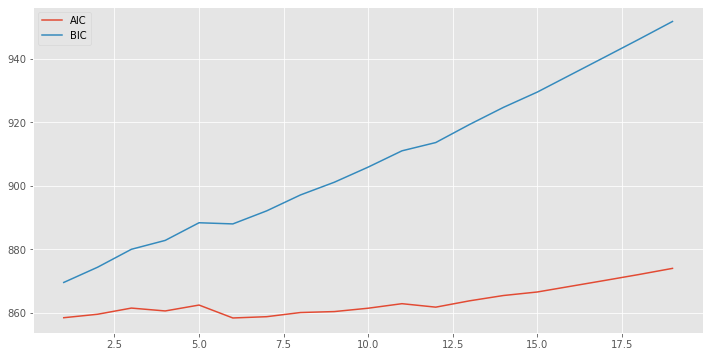

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1,max_lag), aic[1:max_lag], label='AIC')
ax.plot(range(1,max_lag), bic[1:max_lag], label='BIC')
ax.legend()
plt.show()

In this case, an $\text{AR(1)}$ model would be fair good fit. Then we fit it.

In [10]:
mod_obj = ARIMA(ar4_sim, order=(1, 0, 0))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  AR(4)   No. Observations:                  300
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -426.223
Date:                Sat, 15 Oct 2022   AIC                            858.447
Time:                        21:56:45   BIC                            869.558
Sample:                             0   HQIC                           862.894
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0262      0.030      0.871      0.384      -0.033       0.085
ar.L1         -0.9248      0.022    -41.680      0.000      -0.968      -0.881
sigma2         0.9972      0.081     12.343      0.0

# <font face="gotham" color="purple"> MA Model </font>

The _Moving Average_ model is the missing part of workhorse $\text{ARIMA}$. Here is an $\text{MA(1)}$ model
$$
Y_{t}= u_{t}+\theta_{1} u_{t-1}
$$
And the codes for generating $\text{MA}$ series are similar to $\text{AR}$. The plots are for your references.

In [11]:
ar_params = np.array([1]) 
ma_params = np.array([1, 0.9])
ma1 = ArmaProcess(ar_params, ma_params)
ma1_sim = ma1.generate_sample(nsample=100)
ma1_sim = pd.DataFrame(ma1_sim, columns = ['MA(1)'])
ma1_acf = acf_func(ma1_sim.values, fft=False, nlags = 50)

ar_params1 = np.array([1])
ma_params1 = np.array([1, -0.9])
ma1_neg = ArmaProcess(ar_params1, ma_params1)
ma1_sim_neg = ma1_neg.generate_sample(nsample=100)
ma1_sim_neg = pd.DataFrame(ma1_sim_neg, columns = ['MA(1)'])
ma1_acf_neg = acf_func(ma1_sim_neg.values, fft=False, nlags = 50)

ar_params2 = np.array([1])
ma_params2 = np.array([1, 0.8, .2])
ma2 = ArmaProcess(ar_params2, ma_params2)
ma2_sim = ma2.generate_sample(nsample=100)
ma2_sim = pd.DataFrame(ma2_sim, columns = ['MA(2)'])
ma2_acf = acf_func(ma2_sim.values, fft=False, nlags = 50)

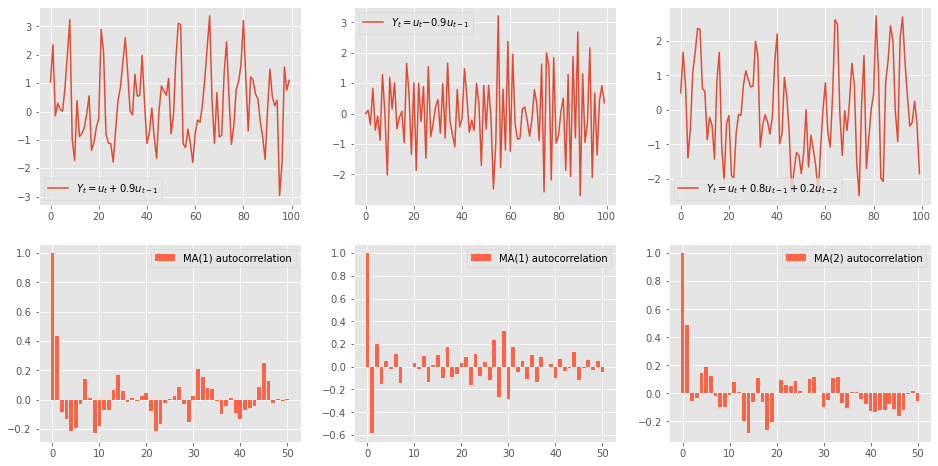

In [12]:
fig, ax = plt.subplots(figsize = (16, 8), nrows = 2, ncols = 3)
ax[0, 0].plot(ma1_sim, label='$Y_t = u_t + {%s} u_{t-1}$'%(ma_params[1]))
ax[0, 0].legend()
ax[1, 0].bar(np.arange(len(ma1_acf)),ma1_acf, color = 'tomato', label = 'MA(1) autocorrelation')
ax[1, 0].legend()

ax[0, 1].plot(ma1_sim_neg, label='$Y_t =  u_t  {%s} u_{t-1}$'%(ma_params1[1]))
ax[0, 1].legend()
ax[1, 1].bar(np.arange(len(ma1_acf_neg)),ma1_acf_neg, color = 'tomato', label = 'MA(1) autocorrelation')
ax[1, 1].legend()

ax[0, 2].plot(ma2_sim, label='$Y_t =  u_t   +{%s} u_{t-1}+ {%s} u_{t-2}  $'%(ma_params2[1], ma_params2[2]))
ax[0, 2].legend()
ax[1, 2].bar(np.arange(len(ma2_acf)),ma2_acf, color = 'tomato', label = 'MA(2) autocorrelation')
ax[1, 2].legend()
plt.show()

# <font face="gotham" color="purple">  Estimation and Forecast of MA</font> 

Estimate the series generated by true relationship
$$
Y_{t}= u_{t}-0.9 u_{t-1}
$$

In [13]:
mod_obj = ARIMA(ma1_sim_neg, order=(0, 0, 1))
result = mod_obj.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  MA(1)   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -133.096
Date:                Sat, 15 Oct 2022   AIC                            272.192
Time:                        21:56:46   BIC                            280.008
Sample:                             0   HQIC                           275.355
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0048      0.010     -0.466      0.641      -0.025       0.015
ma.L1         -0.8938      0.051    -17.514      0.000      -0.994      -0.794
sigma2         0.8253      0.115      7.192      0.0

In [14]:
res_predict = result.predict(start=5, end=110)

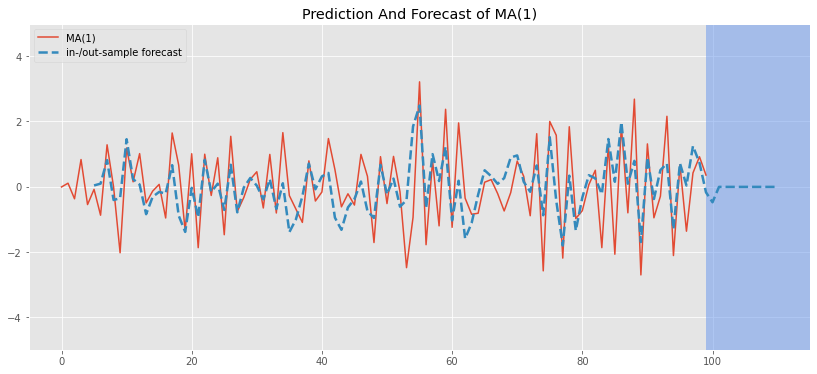

In [15]:
ma1_sim_neg.plot(figsize=(14, 6))
res_predict.plot(label = 'in-/out-sample forecast', title='Prediction And Forecast of MA(1)', ls='--', lw=2.5)
plt.axvspan(len(ar1_sim_pos)-1, len(ar1_sim_pos)+15, alpha=0.5, lw=0, color='CornflowerBlue')
plt.xlim([-5, 115])
plt.ylim([-5, 5])
plt.legend()
plt.show()

Note that all forecasts beyond one-step ahead forecast will all be the identical, namely a straight line in the blue shaded area.

# <font face="gotham" color="purple"> Connections of AR and MA </font>

We can show that any $\text{AR(1)}$ can be rewritten as an $\text{MA($\infty$)}$ model
$$
\text{AR(1)}: \qquad Y_{t}=\phi_0+\phi_{1} Y_{t-1}+u_{t}
$$
Perform a recursive substitution
\begin{align}
Y_t &= \phi_0 + \phi_1(\phi_0 + \phi_1Y_{t-2}+u_{t-1})+u_t = \phi_0 + \phi_1\phi_0+\phi_1^2Y_{t-2}+\phi_1u_{t-1}+u_t\\
    &= \phi_0 + \phi_1\phi_0+\phi_1^2(\phi_0+\phi_1Y_{t-3}+u_{t-2})+\phi_1u_{t-1}+u_t=\phi_0 + \phi_1\phi_0 +\phi_1^2\phi_0 +\phi_1^3Y_{t-3}+\phi_1^2u_{t-2}+\phi_1u_{t-1}+u_t\\
    &\qquad\vdots\\
    &=\frac{\phi_0}{1-\phi_1}+\sum_{i=0}^\infty\phi_1^iu_{t-1}
\end{align}
It holds because of the fact
$$
\lim_{i\rightarrow\infty}\phi_1^iY_{t-i}=0, \qquad-1<\phi <1
$$

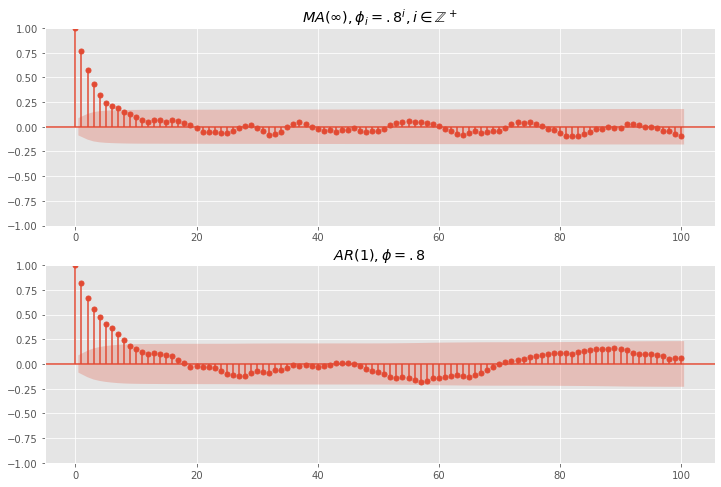

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
ar = np.array([1])
ma = np.array([.8**i for i in range(100)])
mod_obj = ArmaProcess(ar, ma)
ma_sim = mod_obj.generate_sample(nsample=500)
g = plot_acf(ma_sim, ax = ax[0], lags = 100, title ='$MA(\infty), \phi_i = .8^i, i\in \mathbb{Z}^+$')

ar = np.array([1, -.8])
ma = np.array([1])
mod_obj = ArmaProcess(ar, ma)
ar_sim = mod_obj.generate_sample(nsample=500)
g = plot_acf(ar_sim, ax = ax[1], lags = 100, title = '$AR(1), \phi=.8$')

## <font face="gotham" color="purple"> ACF vs PACF </font>

Before the discussion of $\text{ARIMA}$ identification, we shall make some sense out of **autocorrelation function** (ACF) and **partial autocorrelation function** (PACF), which both are classical tools for identifying lags of $\text{ARIMA}$.

We have shown that the formula of sample ACF
$$
\rho_{k}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\sqrt{\operatorname{Var}\left(r_{t}\right) \operatorname{Var}\left(r_{t-k}\right)}}=\frac{\operatorname{Cov}\left(r_{t}, r_{t-k}\right)}{\operatorname{Var}\left(r_{t}\right)}=\frac{\gamma_{k}}{\gamma_{0}}
$$

However, PACF doesn't have a formula. 

Simply speaking, PACF requires removing all correlations in between. e.g. if you are measuring autocorrelation $k$ periods apart, then all influences within the $k$ should be eliminated.

One common way of evaluating PACF is to use demeaned regression
$$
y_t-\bar{y}=\phi_{21} (y_{t-1}-\bar{y})+\phi_{22} (y_{t-2}-\bar{y})+\phi_{33} (y_{t-3}-\bar{y})+u_{t}
$$
Estimates of $\phi_{kk}$ is the partial correlation at lag $3$.

Partial autocorrelation function (PACF) is used for choosing the order of $\text{AR}$ models, in contrast, ACF is for $\text{MA}$ models.

# <font face="gotham" color="purple"> ARMA and ARIMA </font>

Finally, we join $\text{AR}$ and $\text{MA}$ models as $\text{ARMA}$ or $\text{ARMIA}$.

An $\text{ARMA}(1,1)$ process is a straightforward combination of $\text{AR}$ and $\text{MA}$:
$$
Y_{t}=\phi_0+\phi_{1} Y_{t-1}+\theta_{0} u_{t}+\theta_{1} u_{t-1}
$$

In general, $\text{ARMA}(p,q)$ process has the form
$$
Y_t = \phi_0 + \phi_i\sum_{i=1}^pY_{t-i}+\sum_{i=1}^q\theta_i u_{t-i}
$$

And $\text{ARIMA}$ model is essentially the same as $\text{ARMA}$, it mean we have to difference a series $d$ times to render it stationary before applying an $\text{ARIMA}$ model, we say that the original time series is $\text{ARIMA}(p,d,q)$ process. 

By the same token, $\text{ARIMA}(p,0,q)$ process is exactly the same as $\text{ARMA}(p,q)$.

As an example, let's import an FX data.

In [89]:
start = dt.datetime(2020, 1, 1)
end = dt.datetime.today()
df = data.DataReader(['USDCHF=X'], 'yahoo', start, end)['Close'] # pick close price
df = df.join( (np.log(df)-np.log(df).shift()).add_suffix('_')) # add a column with different time, we will change it any way
df.columns = ['USDCHF', 'USDCHF_log_diff']
df = df.dropna()

Here is a technical issue highlighted, note below that ```freq=None```, this could cause an error in the ```ARIMA``` instantiation.

The solution is to explicitly define it as days ```D```.

In [90]:
df.index = pd.DatetimeIndex(df.index).to_period('D')

Now the index is explicitly labeled as days. 

Also divide them into training and test sets.

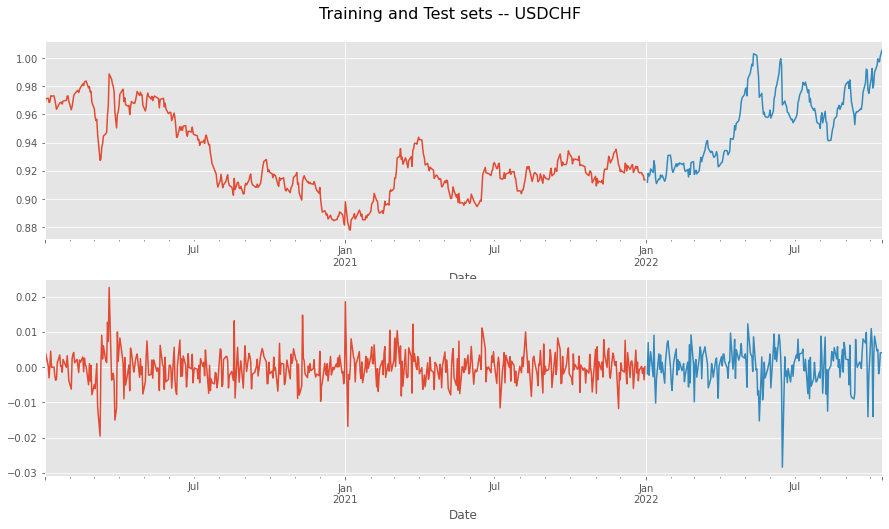

In [128]:
df_test = df.loc[:'2021']
df_train = df.loc['2022':]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
df_test['USDCHF'].plot(ax=ax[0])
df_train['USDCHF'].plot(ax=ax[0])

df_test['USDCHF_log_diff'].plot(ax=ax[1])
df_train['USDCHF_log_diff'].plot(ax=ax[1])
plt.suptitle('Training and Test sets -- USDCHF', size=16, y=.94)
plt.show()

Instantiate a ARMA object.

In [98]:
mod_obj = ARIMA(df['USDCHF_log_diff'], order=(2,0,2))

In [99]:
results = mod_obj.fit()

In [100]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:        USDCHF_log_diff   No. Observations:                  728
Model:                 ARIMA(2, 0, 2)   Log Likelihood                2872.069
Date:                Sun, 16 Oct 2022   AIC                          -5732.139
Time:                        01:22:19   BIC                          -5704.597
Sample:                    01-02-2020   HQIC                         -5721.512
                         - 10-15-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.16e-05      0.000      0.275      0.783      -0.000       0.000
ar.L1         -0.3482      0.478     -0.729      0.466      -1.284       0.588
ar.L2         -0.3294      0.440     -0.749      0.4

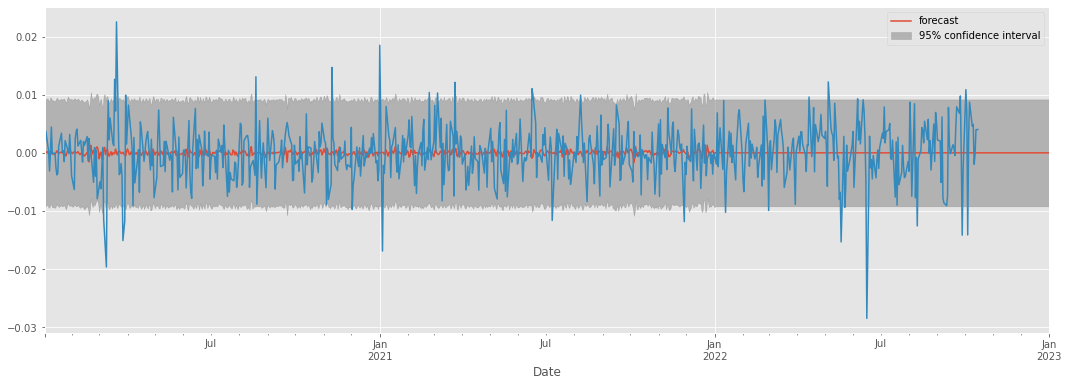

In [103]:
g = tsa.plot_predict(results, start='2020-01-03', end='2023-01-01', alpha=.05, dynamic=False)
df['USDCHF_log_diff'].plot(figsize=(18, 6)); plt.show()

It's actually quite pointless to estimate an $\text{ARIMA}$ model as this example, it almost have no forecast power.